In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, BisectingKMeans
from sklearn.metrics import silhouette_score
import os

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
os.makedirs('../results', exist_ok=True)


In [3]:
# Carregar e preparar dados
df_flights = pd.read_csv('../data/flights_clean.csv')
df = df_flights[df_flights['CANCELLED'] == 0].copy()
df = df.dropna(subset=['DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'DISTANCE', 'AIR_TIME'])

# Filtrar aeroportos com volume mínimo
min_flights = 100
airport_counts = df['ORIGIN_AIRPORT'].value_counts()
airports_with_min_volume = airport_counts[airport_counts >= min_flights].index
df_filtered = df[df['ORIGIN_AIRPORT'].isin(airports_with_min_volume)].copy()

# Agregar métricas por aeroporto
df_airports = df_filtered.groupby('ORIGIN_AIRPORT').agg({
    'DEPARTURE_DELAY': ['mean', 'median', 'std', 'count'],
    'ARRIVAL_DELAY': ['mean', 'median', 'std'],
    'AIR_TIME': ['mean', 'median', 'std'],
    'ELAPSED_TIME': ['mean', 'median', 'std'],
    'TAXI_OUT': ['mean', 'median'],
    'TAXI_IN': ['mean', 'median'],
    'DISTANCE': ['mean', 'min', 'max'],
    'CANCELLED': 'sum',
    'DIVERTED': 'sum'
}).reset_index()

df_airports.columns = ['AIRPORT'] + ['_'.join(col).strip() if col[1] else col[0] 
                                  for col in df_airports.columns[1:]]
df_airports['CANCELLATION_RATE'] = df_airports['CANCELLED_sum'] / df_airports['DEPARTURE_DELAY_count']
df_airports['DIVERTED_RATE'] = df_airports['DIVERTED_sum'] / df_airports['DEPARTURE_DELAY_count']

print(f"Aeroportos analisados: {len(df_airports):,}")


Aeroportos analisados: 587


In [4]:
# Selecionar features e normalizar
features_clustering = [
    'DEPARTURE_DELAY_mean', 'DEPARTURE_DELAY_median', 'DEPARTURE_DELAY_std',
    'ARRIVAL_DELAY_mean', 'ARRIVAL_DELAY_median', 'ARRIVAL_DELAY_std',
    'AIR_TIME_mean', 'AIR_TIME_median', 'AIR_TIME_std',
    'ELAPSED_TIME_mean', 'ELAPSED_TIME_median', 'ELAPSED_TIME_std',
    'TAXI_OUT_mean', 'TAXI_IN_mean',
    'DISTANCE_mean', 'DISTANCE_min', 'DISTANCE_max',
    'DEPARTURE_DELAY_count', 'CANCELLATION_RATE', 'DIVERTED_RATE'
]
features_clustering = [f for f in features_clustering if f in df_airports.columns]

X_cluster = df_airports[features_clustering].copy().dropna()
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

print(f"Features utilizadas: {len(features_clustering)}")
print(f"Aeroportos para clusterização: {len(X_cluster):,}")


Features utilizadas: 20
Aeroportos para clusterização: 587


In [5]:
# ==================================================================================
# ESTUDO DE NÚMERO DE CLUSTERS - K-MEANS
# ==================================================================================
print("="*80)
print("ESTUDO DE NÚMERO DE CLUSTERS - K-MEANS")
print("="*80)

k_range = range(2, 11)
results_kmeans = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(X_cluster_scaled)
    
    inertia = kmeans.inertia_
    silhouette = silhouette_score(X_cluster_scaled, labels)
    
    # Distribuição de clusters
    cluster_counts = pd.Series(labels).value_counts().sort_index()
    cluster_proportions = (cluster_counts / len(labels) * 100).round(2)
    
    results_kmeans.append({
        'k': k,
        'inertia': inertia,
        'silhouette': silhouette,
        'cluster_sizes': cluster_counts.tolist(),
        'cluster_proportions': cluster_proportions.tolist()
    })
    
    print(f"\nk={k}:")
    print(f"  Inertia: {inertia:.2f}")
    print(f"  Silhouette: {silhouette:.4f}")
    print(f"  Distribuição: {dict(zip(cluster_counts.index, cluster_counts.values))}")
    print(f"  Proporções: {dict(zip(cluster_proportions.index, cluster_proportions.values))}")

df_results_kmeans = pd.DataFrame(results_kmeans)


ESTUDO DE NÚMERO DE CLUSTERS - K-MEANS

k=2:
  Inertia: 8346.49
  Silhouette: 0.2836
  Distribuição: {0: np.int64(383), 1: np.int64(204)}
  Proporções: {0: np.float64(65.25), 1: np.float64(34.75)}

k=3:
  Inertia: 7574.89
  Silhouette: 0.1605
  Distribuição: {0: np.int64(186), 1: np.int64(214), 2: np.int64(187)}
  Proporções: {0: np.float64(31.69), 1: np.float64(36.46), 2: np.float64(31.86)}

k=4:
  Inertia: 6712.92
  Silhouette: 0.1697
  Distribuição: {0: np.int64(2), 1: np.int64(207), 2: np.int64(195), 3: np.int64(183)}
  Proporções: {0: np.float64(0.34), 1: np.float64(35.26), 2: np.float64(33.22), 3: np.float64(31.18)}

k=5:
  Inertia: 6152.47
  Silhouette: 0.1687
  Distribuição: {0: np.int64(60), 1: np.int64(224), 2: np.int64(143), 3: np.int64(158), 4: np.int64(2)}
  Proporções: {0: np.float64(10.22), 1: np.float64(38.16), 2: np.float64(24.36), 3: np.float64(26.92), 4: np.float64(0.34)}

k=6:
  Inertia: 5752.86
  Silhouette: 0.1698
  Distribuição: {0: np.int64(224), 1: np.int64(43)

In [6]:
# ==================================================================================
# ESTUDO DE NÚMERO DE CLUSTERS - BISECTING K-MEANS
# ==================================================================================
print("\n" + "="*80)
print("ESTUDO DE NÚMERO DE CLUSTERS - BISECTING K-MEANS")
print("="*80)

results_bisect = []

for k in k_range:
    bisect_kmeans = BisectingKMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    labels = bisect_kmeans.fit_predict(X_cluster_scaled)
    
    inertia = bisect_kmeans.inertia_
    silhouette = silhouette_score(X_cluster_scaled, labels)
    
    # Distribuição de clusters
    cluster_counts = pd.Series(labels).value_counts().sort_index()
    cluster_proportions = (cluster_counts / len(labels) * 100).round(2)
    
    results_bisect.append({
        'k': k,
        'inertia': inertia,
        'silhouette': silhouette,
        'cluster_sizes': cluster_counts.tolist(),
        'cluster_proportions': cluster_proportions.tolist()
    })
    
    print(f"\nk={k}:")
    print(f"  Inertia: {inertia:.2f}")
    print(f"  Silhouette: {silhouette:.4f}")
    print(f"  Distribuição: {dict(zip(cluster_counts.index, cluster_counts.values))}")
    print(f"  Proporções: {dict(zip(cluster_proportions.index, cluster_proportions.values))}")

df_results_bisect = pd.DataFrame(results_bisect)



ESTUDO DE NÚMERO DE CLUSTERS - BISECTING K-MEANS

k=2:
  Inertia: 8346.49
  Silhouette: 0.2836
  Distribuição: {0: np.int64(204), 1: np.int64(383)}
  Proporções: {0: np.float64(34.75), 1: np.float64(65.25)}

k=3:
  Inertia: 7604.04
  Silhouette: 0.2768
  Distribuição: {0: np.int64(190), 1: np.int64(14), 2: np.int64(383)}
  Proporções: {0: np.float64(32.37), 1: np.float64(2.39), 2: np.float64(65.25)}

k=4:
  Inertia: 6882.55
  Silhouette: 0.1744
  Distribuição: {0: np.int64(190), 1: np.int64(14), 2: np.int64(234), 3: np.int64(149)}
  Proporções: {0: np.float64(32.37), 1: np.float64(2.39), 2: np.float64(39.86), 3: np.float64(25.38)}

k=5:
  Inertia: 6410.85
  Silhouette: 0.1755
  Distribuição: {0: np.int64(29), 1: np.int64(161), 2: np.int64(14), 3: np.int64(234), 4: np.int64(149)}
  Proporções: {0: np.float64(4.94), 1: np.float64(27.43), 2: np.float64(2.39), 3: np.float64(39.86), 4: np.float64(25.38)}

k=6:
  Inertia: 6147.19
  Silhouette: 0.1030
  Distribuição: {0: np.int64(29), 1: np.

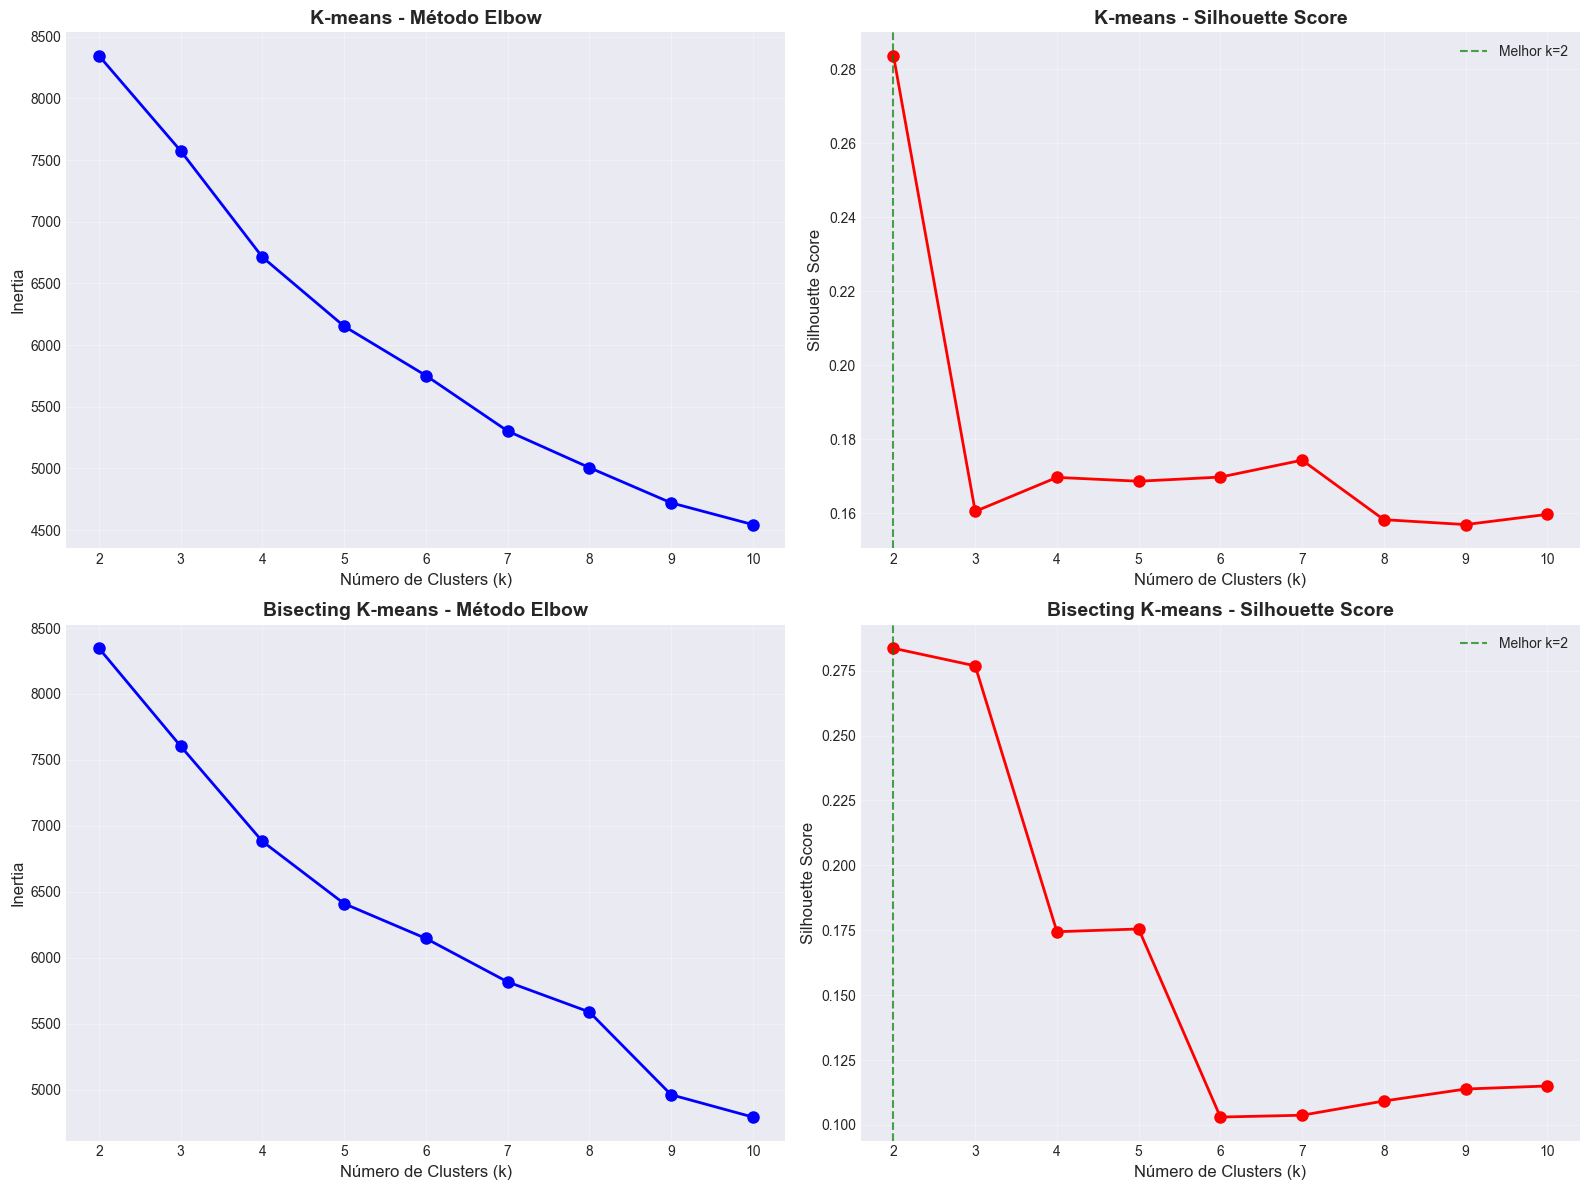


✓ Melhor k K-means: 2 (Silhouette: 0.2836)
✓ Melhor k Bisecting K-means: 2 (Silhouette: 0.2836)


In [7]:
# Visualização dos resultados
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# K-means - Inertia
axes[0, 0].plot(df_results_kmeans['k'], df_results_kmeans['inertia'], 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Número de Clusters (k)', fontsize=12)
axes[0, 0].set_ylabel('Inertia', fontsize=12)
axes[0, 0].set_title('K-means - Método Elbow', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(k_range)

# K-means - Silhouette
axes[0, 1].plot(df_results_kmeans['k'], df_results_kmeans['silhouette'], 'ro-', linewidth=2, markersize=8)
best_k_kmeans = df_results_kmeans.loc[df_results_kmeans['silhouette'].idxmax(), 'k']
axes[0, 1].axvline(x=best_k_kmeans, color='g', linestyle='--', alpha=0.7, label=f'Melhor k={int(best_k_kmeans)}')
axes[0, 1].set_xlabel('Número de Clusters (k)', fontsize=12)
axes[0, 1].set_ylabel('Silhouette Score', fontsize=12)
axes[0, 1].set_title('K-means - Silhouette Score', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(k_range)
axes[0, 1].legend()

# Bisecting K-means - Inertia
axes[1, 0].plot(df_results_bisect['k'], df_results_bisect['inertia'], 'bo-', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Número de Clusters (k)', fontsize=12)
axes[1, 0].set_ylabel('Inertia', fontsize=12)
axes[1, 0].set_title('Bisecting K-means - Método Elbow', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(k_range)

# Bisecting K-means - Silhouette
axes[1, 1].plot(df_results_bisect['k'], df_results_bisect['silhouette'], 'ro-', linewidth=2, markersize=8)
best_k_bisect = df_results_bisect.loc[df_results_bisect['silhouette'].idxmax(), 'k']
axes[1, 1].axvline(x=best_k_bisect, color='g', linestyle='--', alpha=0.7, label=f'Melhor k={int(best_k_bisect)}')
axes[1, 1].set_xlabel('Número de Clusters (k)', fontsize=12)
axes[1, 1].set_ylabel('Silhouette Score', fontsize=12)
axes[1, 1].set_title('Bisecting K-means - Silhouette Score', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xticks(k_range)
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('../results/estudo_clusters_aeroporto.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Melhor k K-means: {int(best_k_kmeans)} (Silhouette: {df_results_kmeans['silhouette'].max():.4f})")
print(f"✓ Melhor k Bisecting K-means: {int(best_k_bisect)} (Silhouette: {df_results_bisect['silhouette'].max():.4f})")


In [8]:
# ==================================================================================
# ESTUDO DE COMPONENTES PRINCIPAIS (PCA)
# ==================================================================================
print("\n" + "="*80)
print("ESTUDO DE COMPONENTES PRINCIPAIS (PCA)")
print("="*80)

# Calcular PCA com todos os componentes
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_cluster_scaled)

# Variância explicada
variance_explained = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(variance_explained)

print(f"\nTotal de componentes: {len(variance_explained)}")
print(f"\nVariância explicada por componente (top 10):")
for i in range(min(10, len(variance_explained))):
    print(f"  PC{i+1}: {variance_explained[i]:.2%}")

print(f"\nVariância acumulada:")
for threshold in [0.80, 0.90, 0.95]:
    n_components = np.where(cumulative_variance >= threshold)[0][0] + 1
    print(f"  {threshold:.0%} de variância: {n_components} componentes ({cumulative_variance[n_components-1]:.2%})")



ESTUDO DE COMPONENTES PRINCIPAIS (PCA)

Total de componentes: 20

Variância explicada por componente (top 10):
  PC1: 37.70%
  PC2: 19.40%
  PC3: 11.44%
  PC4: 6.89%
  PC5: 5.40%
  PC6: 4.73%
  PC7: 4.21%
  PC8: 3.81%
  PC9: 2.72%
  PC10: 1.88%

Variância acumulada:
  80% de variância: 5 componentes (80.82%)
  90% de variância: 8 componentes (93.57%)
  95% de variância: 9 componentes (96.28%)


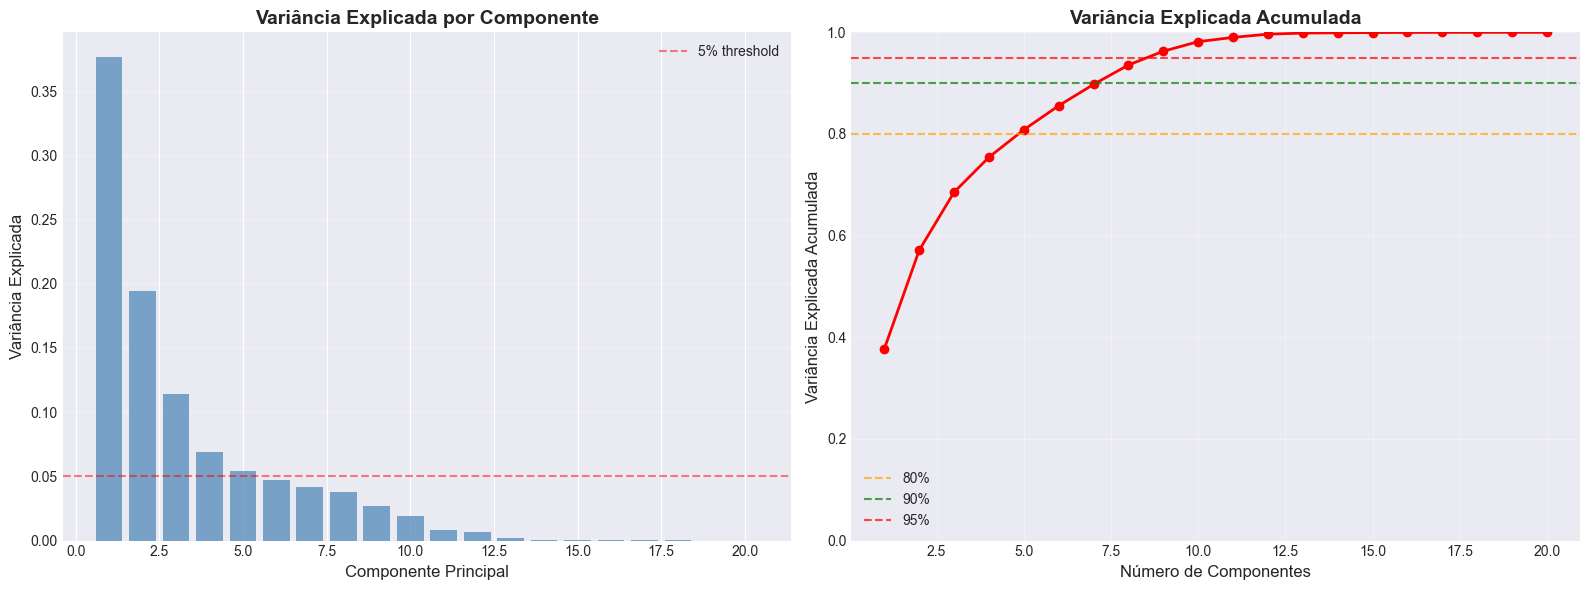

In [9]:
# Visualização do estudo de PCA
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Variância explicada por componente
n_show = min(20, len(variance_explained))
axes[0].bar(range(1, n_show + 1), variance_explained[:n_show], alpha=0.7, color='steelblue')
axes[0].set_xlabel('Componente Principal', fontsize=12)
axes[0].set_ylabel('Variância Explicada', fontsize=12)
axes[0].set_title('Variância Explicada por Componente', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].axhline(y=0.05, color='r', linestyle='--', alpha=0.5, label='5% threshold')
axes[0].legend()

# Variância acumulada
axes[1].plot(range(1, n_show + 1), cumulative_variance[:n_show], 'ro-', linewidth=2, markersize=6)
axes[1].axhline(y=0.80, color='orange', linestyle='--', alpha=0.7, label='80%')
axes[1].axhline(y=0.90, color='green', linestyle='--', alpha=0.7, label='90%')
axes[1].axhline(y=0.95, color='red', linestyle='--', alpha=0.7, label='95%')
axes[1].set_xlabel('Número de Componentes', fontsize=12)
axes[1].set_ylabel('Variância Explicada Acumulada', fontsize=12)
axes[1].set_title('Variância Explicada Acumulada', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.savefig('../results/estudo_pca_aeroporto.png', dpi=300, bbox_inches='tight')
plt.show()


In [10]:
# Resumo dos resultados
print("\n" + "="*80)
print("RESUMO DOS RESULTADOS")
print("="*80)

print("\n1. ESTUDO DE CLUSTERS:")
print(f"   Melhor k (K-means): {int(best_k_kmeans)}")
print(f"   Melhor k (Bisecting K-means): {int(best_k_bisect)}")

print("\n2. ESTUDO DE PCA:")
for threshold in [0.80, 0.90, 0.95]:
    n_components = np.where(cumulative_variance >= threshold)[0][0] + 1
    print(f"   {threshold:.0%} de variância: {n_components} componentes")

print("\n✓ Análises concluídas!")



RESUMO DOS RESULTADOS

1. ESTUDO DE CLUSTERS:
   Melhor k (K-means): 2
   Melhor k (Bisecting K-means): 2

2. ESTUDO DE PCA:
   80% de variância: 5 componentes
   90% de variância: 8 componentes
   95% de variância: 9 componentes

✓ Análises concluídas!
